<a href="https://colab.research.google.com/github/Sh4rt/data_mining/blob/main/Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install unar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgnustep-base1.26
The following NEW packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgnustep-base1.26
  unar
0 upgraded, 5 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,947 kB of archives.
After this operation, 14.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-common amd64 2.7.0-4 [39.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-common all 1.26.0-7 [70.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libgnustep-base1.26 amd64 1.26.0-7 [1,331 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-runtime amd64 1.26.0-7 [208 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/universe amd64 un

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unar drive/MyDrive/CatsDogs.rar -o drive/MyDrive/dataset -q
print("Done unarchiving")

  CatsDogs/cats/cat.1.jpg  (16880 B)... Skipping existing file.
Extraction to directory "drive/MyDrive/dataset" failed (1 file failed.)
Done unarchiving


In [ ]:
import tensorflow as tf
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
import time 

tqdm.pandas()


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
IMAGE_SIZE = (224,224,3)
MODELS_DIR = Path('drive/MyDrive/Models/BinaryClassification')
MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR = Path('drive/MyDrive/dataset/CatsDogs')
FULLSET_DIR = DATASET_DIR.joinpath('full_set')

In [ ]:
# Создадим датафрейм куда будем писать результаты экспериментов

df_results = pd.DataFrame(columns=['Model_name', 'Loss', 'Accuracy', 'time'])

## Подготовка данных

##TF.DATA

Мы создаем csv файлы с train, val и test(если надо). В них сохраняем раскладку картинок и в будущем подгружаем tf.Data

In [ ]:
files = [(file, file.parent.name) for file in FULLSET_DIR.glob('**/*.jpg')]
df_dataset = pd.DataFrame(data=files,
                          columns=['File', 'Label'])
df_dataset['Label_i'] = df_dataset['Label'].astype('category').cat.codes
train, test = train_test_split(df_dataset, test_size=0.3, stratify=df_dataset['Label_i'], random_state=89)
test, valid = train_test_split(test, test_size=0.5, stratify=test['Label_i'], random_state=89)
print(f"{train.shape=}, {test.shape=}, {valid.shape=}")

train.to_csv(DATASET_DIR.joinpath('train.csv'), index=False)
test.to_csv(DATASET_DIR.joinpath('test.csv'), index=False)
valid.to_csv(DATASET_DIR.joinpath('valid.csv'), index=False)

train.shape=(2800, 3), test.shape=(600, 3), valid.shape=(600, 3)


In [ ]:
import pandas as pd

train_df = pd.read_csv(DATASET_DIR.joinpath('train.csv'))
test_df = pd.read_csv(DATASET_DIR.joinpath('test.csv'))
valid_df = pd.read_csv(DATASET_DIR.joinpath('valid.csv'))

print(f"train_df = {train_df.shape}, test_df = {test_df.shape}, valid_df = {valid_df.shape}")

train_df = (2800, 3), test_df = (600, 3), valid_df = (600, 3)


In [ ]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, size=IMAGE_SIZE[:2])
    image = tf.cast(image, tf.float32)
    return image, label


train_ds = tf.data.Dataset.from_tensor_slices((train_df['File'].values, train_df['Label_i'].values))


train_ds = train_ds.shuffle(buffer_size=len(train_ds), reshuffle_each_iteration=True)
train_ds = train_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

test_ds = tf.data.Dataset.from_tensor_slices((test_df['File'].values, test_df['Label_i'].values))
test_ds = test_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

val_ds = tf.data.Dataset.from_tensor_slices((valid_df['File'].values, valid_df['Label_i'].values))
val_ds = val_ds.map(load_image, num_parallel_calls=-1).batch(32).prefetch(-1)

# TODO test_ds

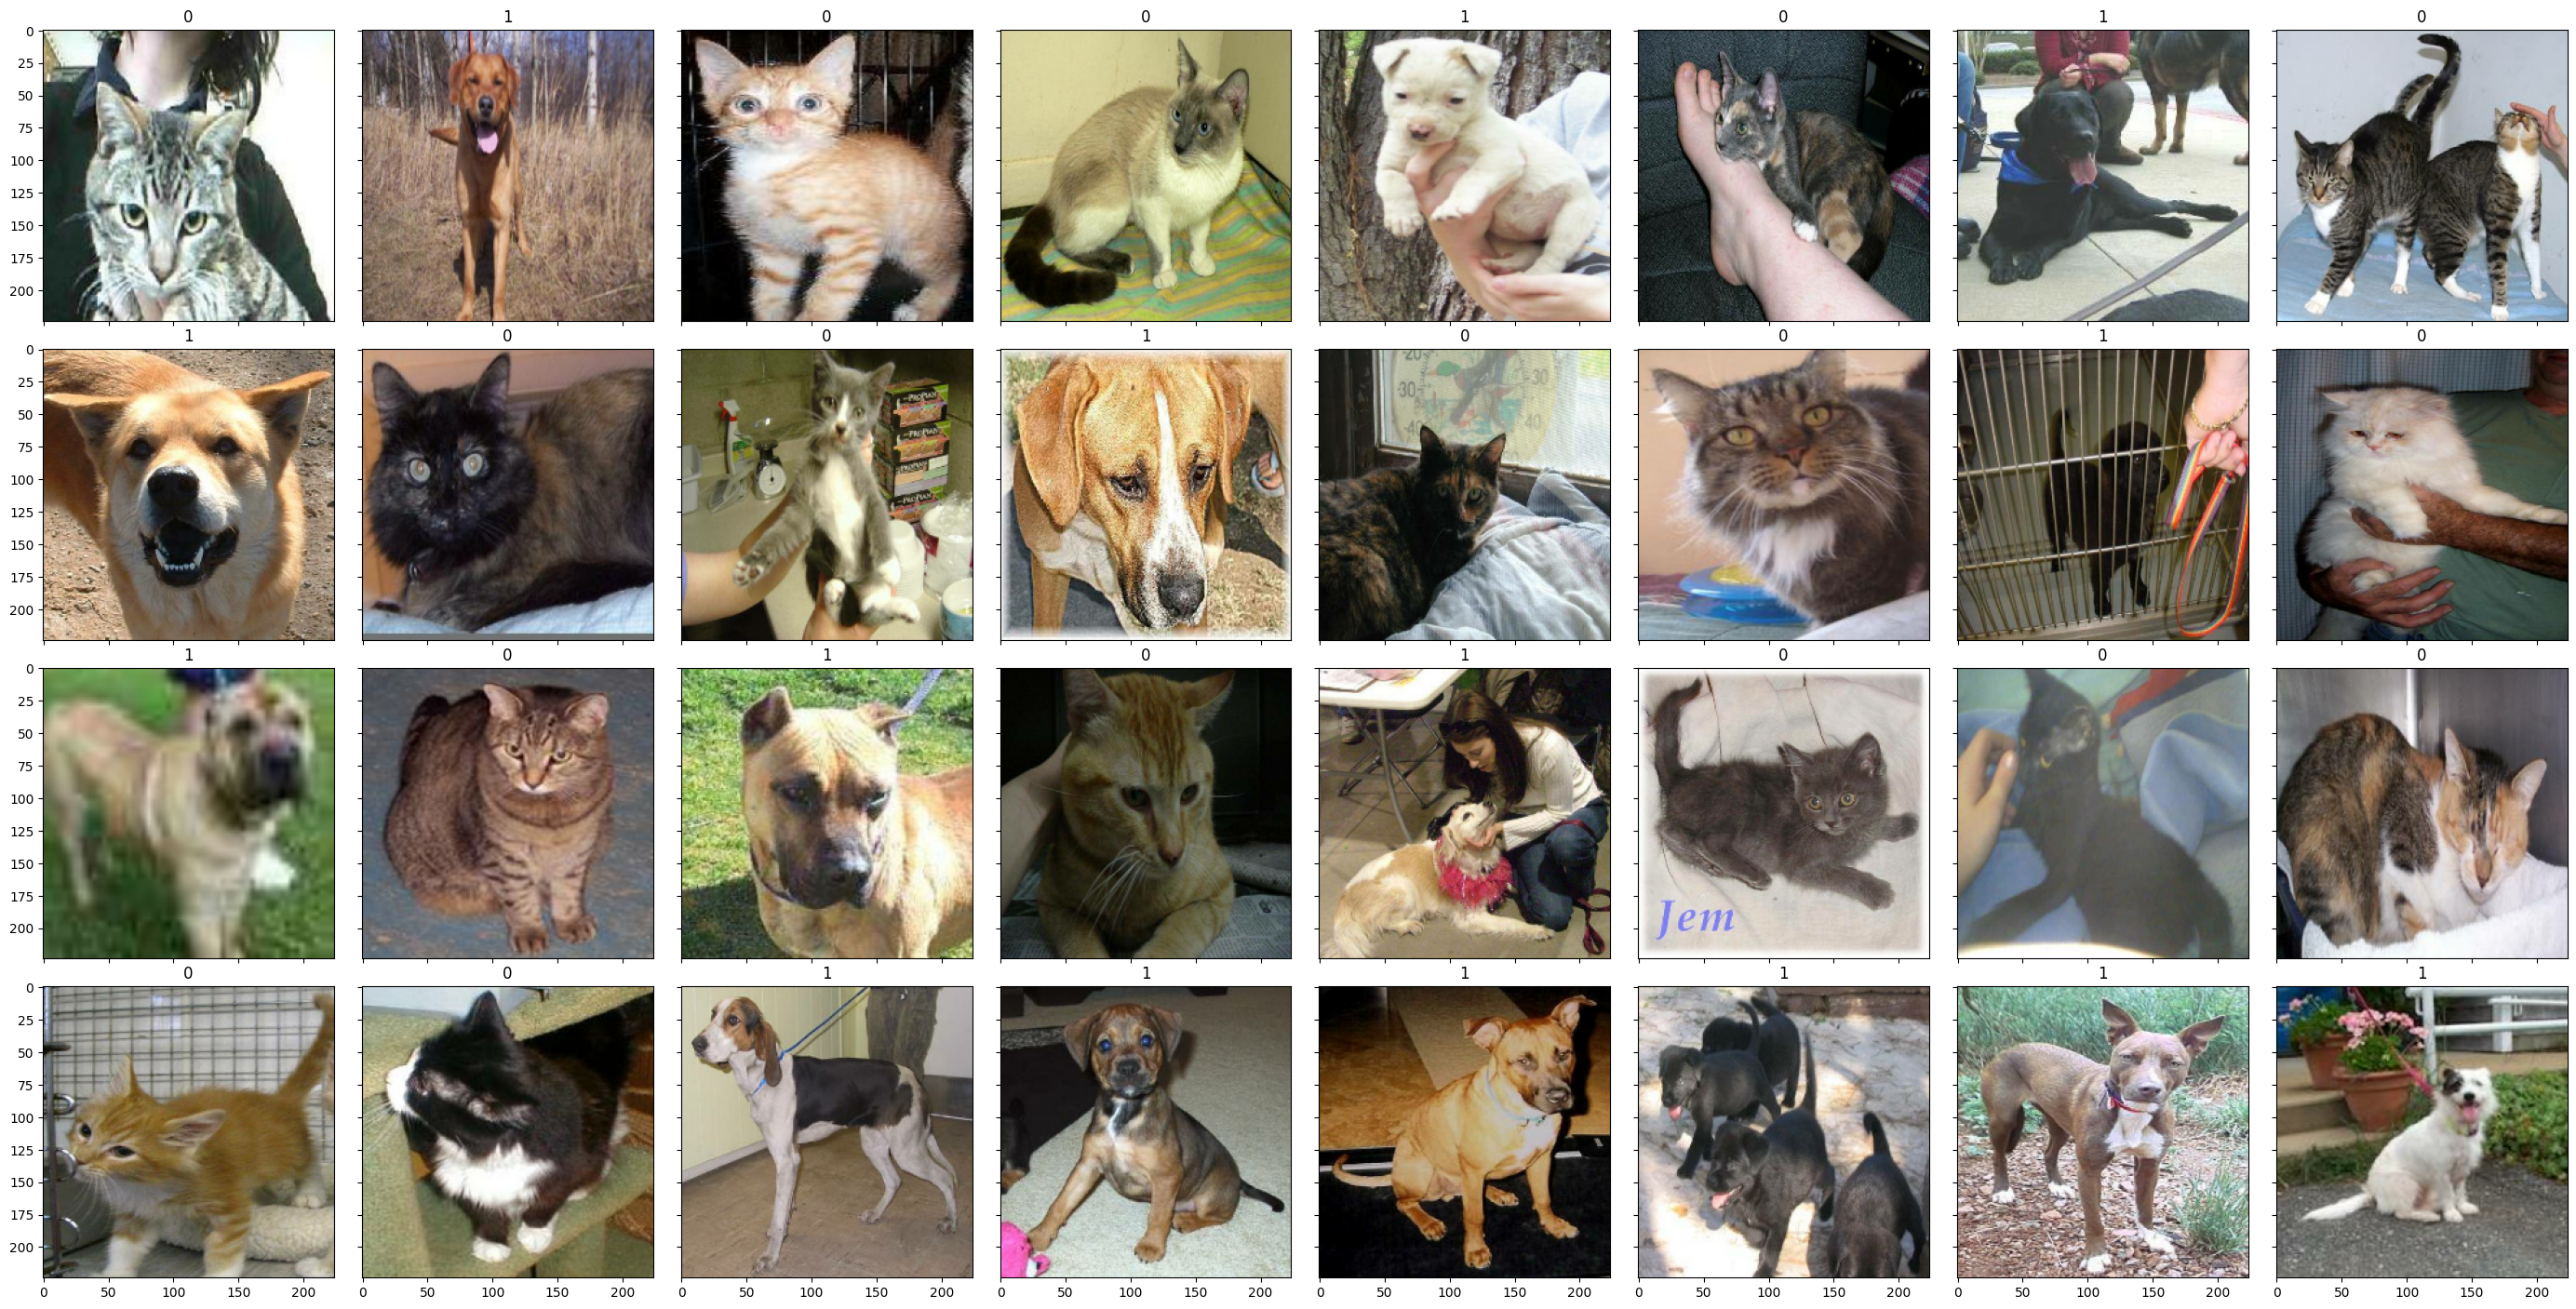

In [ ]:
im_batch_plus_lbl, lbl_batch = next(iter(train_ds))
im_batch = im_batch_plus_lbl

fig = plt.figure(figsize=(35, 35))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )
for i, grid in enumerate(zip(grid, im_batch)):
    ax, im = grid    
    ax.imshow(tf.cast(im,tf.int32))
    ax.set_title(lbl_batch[i].numpy(), fontdict=None, loc='center', color = "k")

plt.show()

##CALLBACKS

In [ ]:
def generate_callbacks():
    MODELS_DIR.joinpath('cp').mkdir(parents=True, exist_ok=True)
    MODELS_DIR.joinpath('logs').mkdir(parents=True, exist_ok=True)

    reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                            factor=0.2,
                                            patience=2,
                                            verbose=1,
                                            min_delta=0.000001,
                                            cooldown=0,
                                            min_lr=0.0000001)

    chk_path = MODELS_DIR.joinpath('cp', 'ckpt_{epoch:02d}.ckpt')
    checkpointer = tf.keras.callbacks.ModelCheckpoint(chk_path, save_best_only=True, verbose=1, save_weights_only=True)
    stopper = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, min_delta=0.0001, verbose=1)
    logger = CSVLogger(MODELS_DIR.joinpath("logs", f"training_log.csv"), separator=';', append=True)

    logs = "logs/" + datetime.now().strftime("thresh_%Y%m%d-%H%M%S")
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                    histogram_freq = 1,
                                                    profile_batch = '200,205')


    callbacks = [reduce_learning_rate,
                checkpointer,
                stopper,
                logger,             
    ]
    return callbacks

callbacks = generate_callbacks()
print('Done')

Done


## Учим самодельную модель

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    ],
    name='augmentation'
    
)

inputs = tf.keras.Input(shape=IMAGE_SIZE)
x = inputs/255.
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
# x = layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0     

In [ ]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
)

Epoch 1/100
88/88 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5239
Epoch 1: val_loss improved from inf to 0.68994, saving model to drive/MyDrive/Models/BinaryClassification/cp/ckpt_01.ckpt
88/88 [==============================] - 211s 2s/step - loss: 0.6970 - accuracy: 0.5239 - val_loss: 0.6899 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 2/100
87/88 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5471
Epoch 2: val_loss improved from 0.68994 to 0.65512, saving model to drive/MyDrive/Models/BinaryClassification/cp/ckpt_02.ckpt
88/88 [==============================] - 8s 91ms/step - loss: 0.6865 - accuracy: 0.5479 - val_loss: 0.6551 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/100
87/88 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.6142
Epoch 3: val_loss improved from 0.65512 to 0.62504, saving model to drive/MyDrive/Models/BinaryClassification/cp/ckpt_03.ckpt
88/88 [==============================] - 201s 2s/step -

In [ ]:
import matplotlib.pyplot as plt

def show_results(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(accuracy)+1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.legend()
    plt.title("Training and validation accuracy")
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.legend()
    plt.title("Training and validation loss")
    plt.show()

show_results(history)

In [ ]:
# Saving model

model.save(MODELS_DIR.joinpath('self_made_wo_augm.h5'))
print("Model saved")

In [ ]:
#show test results

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
import os

model_path = MODELS_DIR.joinpath('self_made_wo_augm.h5')
model_size = os.path.getsize(model_path)

print(f"Model size: {model_size} bytes")

In [ ]:
model_size